In [188]:
import tensorflow as tf
import numpy as np
import os
import cv2

dir_path = './datasets/WEBCAM_1'

def load_dataset():
    # Load images and labels
    images = []
    labels = []

    shape = (76, 76, 3)
    
    for filename in os.listdir(os.path.join(dir_path)):
        img = cv2.imread(os.path.join(dir_path, filename), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None and img.shape == shape:
            images.append(img)
            
            if 'false' in filename:
                labels.append(0)
            else:
                labels.append(1)
    
    X = np.array(images)
    y = np.array(labels)
        
    return X, y

# Define different augmentations
def flip_left_right(image):
    return tf.image.random_flip_left_right(image)

def flip_up_down(image):
    return tf.image.random_flip_up_down(image)

def brightness(image):
    return tf.image.random_brightness(image, max_delta=0.1)

def contrast(image):
    return tf.image.random_contrast(image, lower=0.1, upper=0.2)

def saturation(image):
    return tf.image.random_saturation(image, lower=0.5, upper=1.5)

def hue(image):
    return tf.image.random_hue(image, max_delta=0.2)

def central_crop(image):
    return tf.image.central_crop(image, central_fraction=0.8)

# List of augmentation functions
augmentations = [flip_left_right, flip_up_down, brightness, contrast, saturation, hue]

def random_augment(image):
    # Randomly select and apply an augmentation function
    augment = np.random.choice(augmentations)
    return augment(image)

X, y = load_dataset()

# Convert to TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Create augmented datasets and concatenate to the original dataset
combined_dataset = dataset
for _ in range(5):  # Increase to desired multiple, 2 for triple size
    augmented_dataset = dataset.map(lambda x, y: (random_augment(x), y))
    combined_dataset = combined_dataset.concatenate(augmented_dataset)

In [189]:
# Convert the combined_dataset back to X, y
X_list = []
y_list = []

# Iterate over the combined_dataset
for images, labels in combined_dataset:
    X_list.append(images.numpy())
    y_list.append(labels.numpy())

# Convert lists to numpy arrays
X = np.array(X_list)
X = X[..., np.newaxis]

y = np.array(y_list)

X.shape, y.shape

((1866, 76, 76, 3, 1), (1866,))

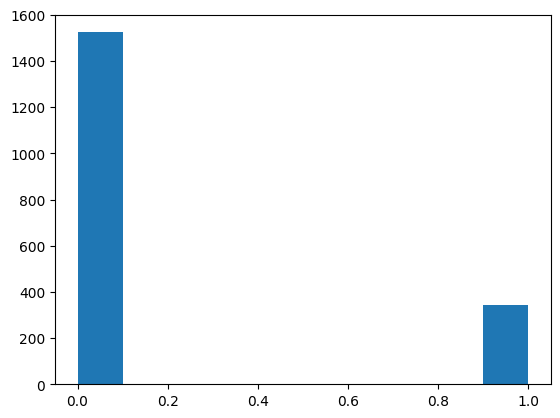

In [190]:
plt.hist(y);

In [191]:
from sklearn.model_selection import train_test_split

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import metrics


# Create a CNN model
model = Sequential()

# Add a convolution layer
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(76, 76, 3)))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer
model.add(Conv2D(64, kernel_size=3, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the tensor output from the previous layer
model.add(Flatten())
# Replace the Flatten layer with GlobalMaxPooling2D
#model.add(GlobalMaxPooling2D())

# Add a dense layer
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()    
    ]
)

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15)

Epoch 1/15
47/47 [==============================] - 15s 284ms/step - loss: 10.1504 - accuracy: 0.8365 - precision_4: 0.5635 - recall_2: 0.5145 - val_loss: 0.2054 - val_accuracy: 0.9144 - val_precision_4: 0.7237 - val_recall_2: 0.8333
Epoch 2/15
47/47 [==============================] - 12s 264ms/step - loss: 0.3471 - accuracy: 0.9109 - precision_4: 0.7871 - recall_2: 0.7101 - val_loss: 0.2693 - val_accuracy: 0.9037 - val_precision_4: 0.6875 - val_recall_2: 0.8333
Epoch 3/15
47/47 [==============================] - 14s 290ms/step - loss: 0.2056 - accuracy: 0.9336 - precision_4: 0.8020 - recall_2: 0.8514 - val_loss: 0.2901 - val_accuracy: 0.9011 - val_precision_4: 0.9677 - val_recall_2: 0.4545
Epoch 4/15
47/47 [==============================] - 14s 295ms/step - loss: 0.0780 - accuracy: 0.9792 - precision_4: 0.9455 - recall_2: 0.9420 - val_loss: 0.0604 - val_accuracy: 0.9893 - val_precision_4: 0.9844 - val_recall_2: 0.9545
Epoch 5/15
47/47 [==============================] - 14s 301ms/step 

In [194]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 74, 74, 64)        1792      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 35, 35, 64)        36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 18496)             0         
                                                                 
 dense_36 (Dense)            (None, 64)              

In [195]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

12/12 - 1s - loss: 0.0914 - accuracy: 0.9813 - precision_4: 0.9275 - recall_2: 0.9697 - 852ms/epoch - 71ms/step


ValueError: too many values to unpack (expected 2)

In [ ]:
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
import matplotlib.pyplot as plt

i = 12

plt.imshow(X_test[i][:,:,:,0])
plt.show()

print(y_test[i], y_pred[i])

In [ ]:
model.save('models/model_webcam_1_v1.h5')

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model('models/model_webcam_1_v1.h5')